필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
# jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
jsb_yearly = pd.read_excel(base_path+"Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [10]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [12]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [13]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [16]:
# jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
jsb_flow_yearly = pd.read_excel(base_path+"Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [17]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [18]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [19]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [20]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [21]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [22]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [23]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [24]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [25]:
jsb_data = jsb_data[:82064]

In [26]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [27]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [28]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [29]:
list(jsb_data.columns)[:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]

['측정일/월',
 '측정소명',
 '수온 ℃',
 '수소이온농도',
 '전기전도도 μS/cm',
 '용존산소 mg/L',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [30]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [31]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)',
       '방류량(㎥/s)'],
      dtype='object')

In [32]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [33]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
수소이온농도         0.121515
전기전도도 μS/cm    0.120942
용존산소 mg/L      0.134846
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [34]:
len(jsb_data)

82064

시간데이터 추가

In [35]:
jsb_df = jsb_data.copy()

In [36]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)',
       '방류량(㎥/s)'],
      dtype='object')

In [37]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [38]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '수소이온농도',
 '전기전도도 μS/cm',
 '용존산소 mg/L',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [39]:
for var in col_c[2:]:
    for i in range(1, 73):
        jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)

C:\Users\gslee\AppData\Local\Temp\ipykernel_23388\3671321184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)
C:\Users\gslee\AppData\Local\Temp\ipykernel_23388\3671321184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)
C:\Users\gslee\AppData\Local\Temp\ipykernel_23388\3671321184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [40]:
len(jsb_df)

82064

In [41]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=733)

In [42]:
len(jsb_df)

82064

결측치 보간법

In [43]:
from datetime import datetime

In [44]:
jsb_df = jsb_df.copy()

In [45]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [46]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [47]:
jsb_df = jsb_df.dropna()

In [48]:
jsb_df.__len__()

79891

In [49]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥',
       ...
       '63shift방류량(㎥/s)', '64shift방류량(㎥/s)', '65shift방류량(㎥/s)',
       '66shift방류량(㎥/s)', '67shift방류량(㎥/s)', '68shift방류량(㎥/s)',
       '69shift방류량(㎥/s)', '70shift방류량(㎥/s)', '71shift방류량(㎥/s)',
       '72shift방류량(㎥/s)'],
      dtype='object', length=732)

In [50]:
col = list(jsb_df.columns[2:])
print(col)

['수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '49shift수온 ℃', '50shift수온 ℃', '51shift수온 ℃', '52shift수온 ℃', '53shift수온 ℃', '54shift수온 ℃', '55shift수온 ℃', '56shift수온 ℃', '57shift수온 ℃', '58shift수온 ℃', '59shift수온 ℃

In [51]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '49shift수온 ℃', '50shift수온 ℃', '51shift수온 ℃', '52shift수온 ℃', '53shift수온 ℃', '54shift수온 ℃', '55shift수온 ℃', '56shift수온 ℃', '57shift수온 ℃', '58shift수온 ℃', '59shift수온 ℃', '60shift수온 ℃

피처 정규화 없이

In [52]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[10], 'learning_rate':[0.05]}
# parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [55]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [56]:
gb_grid.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.967 total time=34.0min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.967 total time=34.5min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.968 total time=34.6min


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05], 'max_depth': [10]},
             verbose=5)

In [57]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [58]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.05, 'max_depth': 10}",0.967263,1


In [59]:
gb_grid.best_params_s

AttributeError: 'GridSearchCV' object has no attribute 'best_params_s'

In [60]:
estimator = gb_grid.best_estimator_

In [61]:
pred = estimator.predict(X_test)

In [62]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.4 수소이온농도
0.01 전기전도도 μS/cm
0.1 용존산소 mg/L
0.03 탁도 NTU
0.03 총유기탄소 mg/L
0.02 총질소 mg/L
0.0 총인 mg/L
0.0 상류수위(EL.m)
0.0 방류량(㎥/s)
0.02 1shift수온 ℃
0.0 2shift수온 ℃
0.0 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.0 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.0 32shift수온 ℃
0.0 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.0 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.0 43shift수온 ℃
0.0 44shift수온 ℃
0.0 45shift수온 ℃
0.0 46shift수온 ℃
0.0 47shift수온 ℃
0.0 48shift수온 ℃
0.0 49shift수온 ℃
0.0 50shift수온 ℃
0.0 51shift수온 ℃
0.0 52shift수온 ℃
0.0 53shift수온 ℃
0.0 54shift수온 ℃
0.0 55shift수온 ℃
0.0 

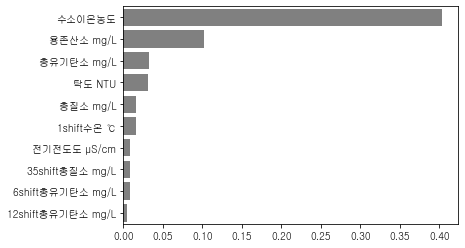

In [63]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [64]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.972671013568797


In [65]:
feature_series[:10]

수소이온농도               0.403707
용존산소 mg/L            0.102167
총유기탄소 mg/L           0.032514
탁도 NTU               0.030738
총질소 mg/L             0.016505
1shift수온 ℃           0.015910
전기전도도 μS/cm          0.008874
35shift총질소 mg/L      0.008738
6shift총유기탄소 mg/L     0.008490
12shift총유기탄소 mg/L    0.005156
dtype: float64

피처 정규화

In [ ]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [ ]:
jsb_df_scaled.head()

In [ ]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [ ]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [ ]:
gb_grids.fit(X_trains, np.log1p(y_trains))

In [ ]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [ ]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

In [ ]:
gb_grids.best_params_

In [ ]:
estimators = gb_grids.best_estimator_

In [ ]:
preds = estimators.predict(X_tests)

In [ ]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

In [ ]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [ ]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

In [ ]:
feature_series[:10]